In [1]:
from pyabc import (ABCSMC, Distribution, RV, History)
from pyabc.visualization import plot_kde_matrix, kde_1d
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


### Load the study data

In [2]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)

In [3]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

### Load the completed AMC-SMC run

In [5]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_12_20.db"))
history = History(db_path)
history.id = 1

### Show posterior for last generation

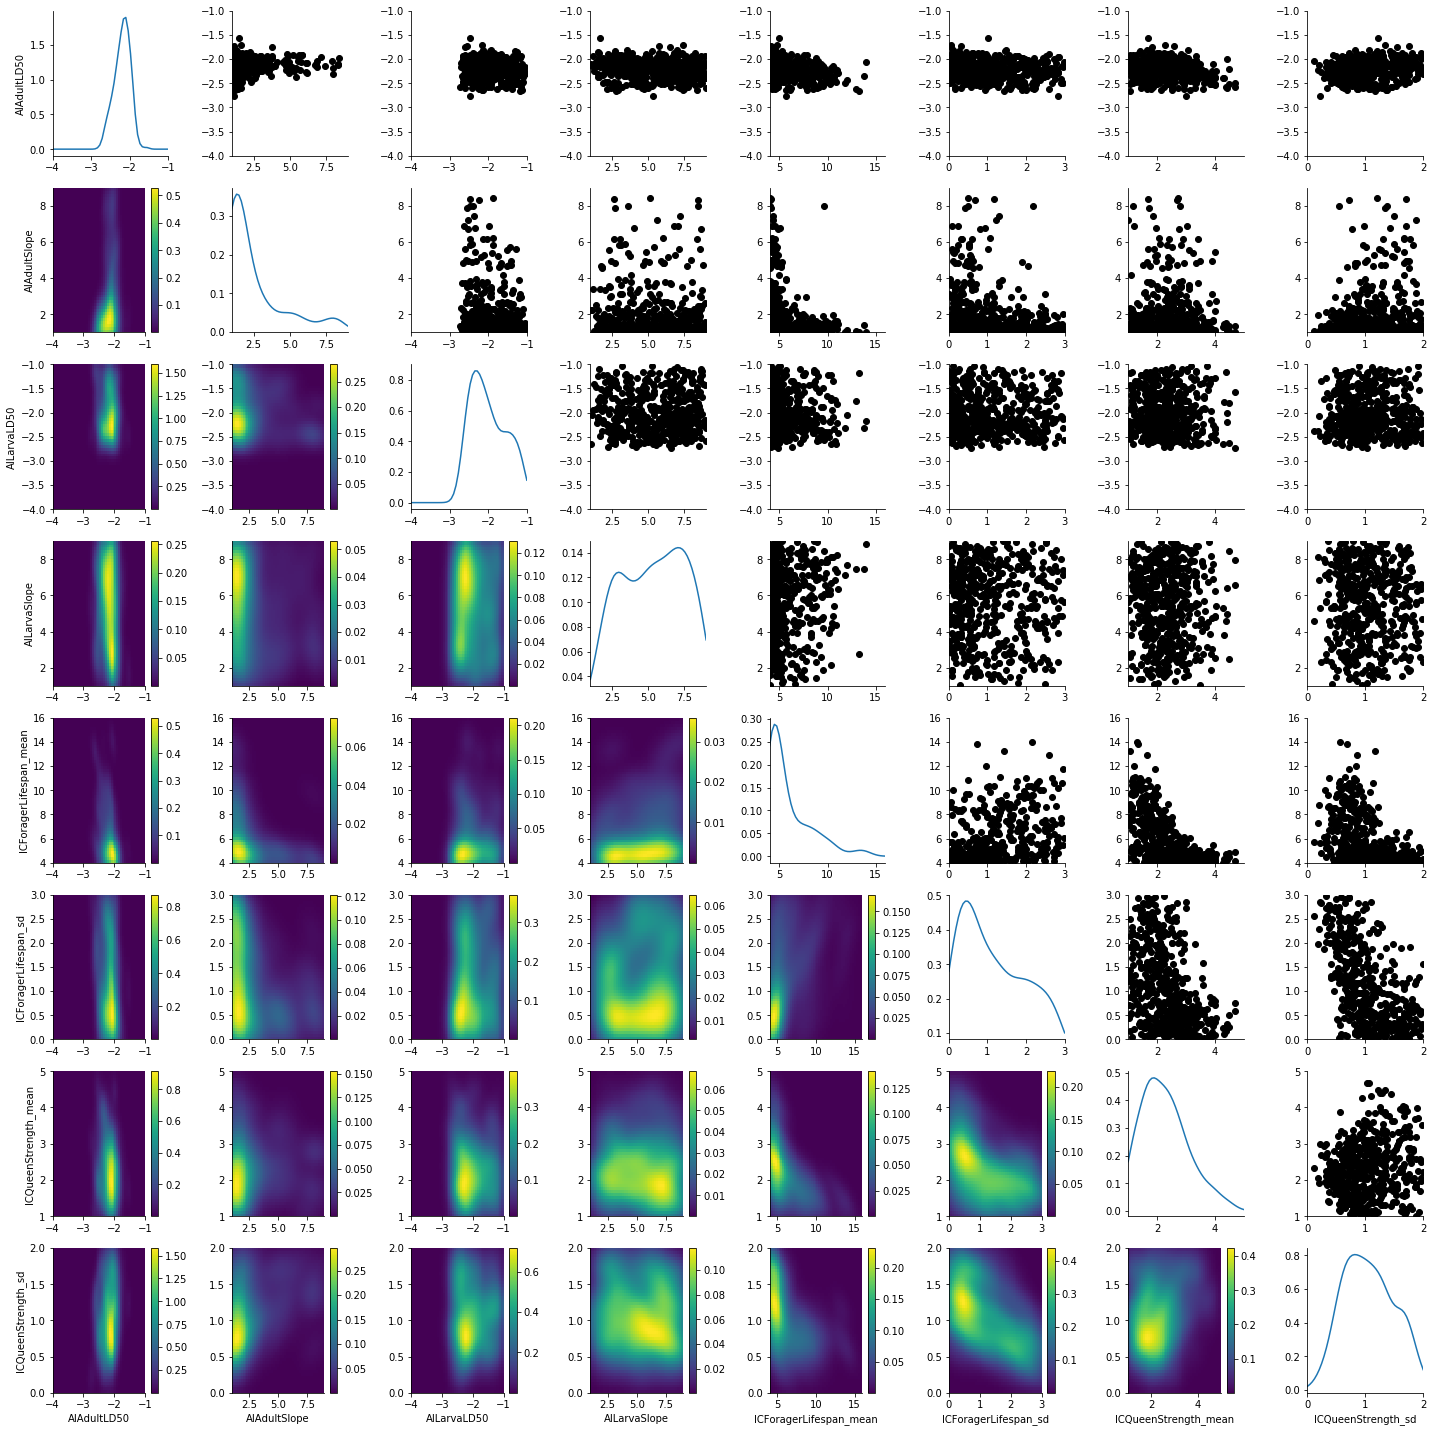

In [9]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)
plot_kde_matrix(df, w, limits=limits);

### Draw from posterior to predict dose-response curve for adults

We can draw from our last generation of particles, with probabilty proportional to their weights, to sample the posterior.
Draws of ld50 and slope can be combined to plot dose-response curves.

LD50: 4.405840272374662, Slope: 1.137422996211816


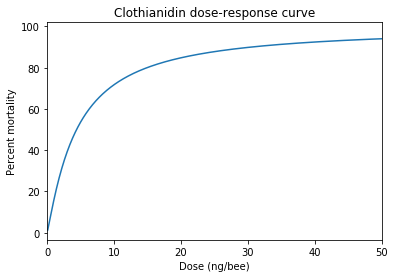

In [211]:
import random

def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

def plot_dose_response(ld50, slope, xlim=100, max_dose=100):
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50/x)**slope) #four parameters Hill equation, equal to what VarroaPop uses
    fix, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='Dose (ng/bee)', ylabel='Percent mortality', title='Clothianidin dose-response curve', xlim=(0,xlim))
    plt.show()
 
random.seed(1251)
sample = draw_posterior(df, w, 1)

#Plot a single curve
sample_ld50 = (10**sample.iloc[0,0]) * 1000
sample_slope = sample.iloc[0,1]
print("LD50: {}, Slope: {}".format(sample_ld50, sample_slope))
plot_dose_response(sample_ld50, sample_slope, xlim=50)

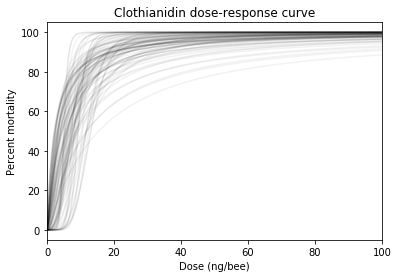

In [281]:
### Plot many curves together

def plot_all_dr(sample, xlim=100, max_dose=100, adult=True):
    fix, ax = plt.subplots()
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    ld50_col, slope_col = 0, 1
    if not adult:
        ld50_col, slope_col = ld50_col+2, slope_col+2
    for index, row in sample.iterrows():
        ld50 = (10**row[ld50_col]) * 1000
        slope = row[slope_col]
        y = 100/(1+(ld50/x)**slope) #four parameters Hill equation
        ax.plot(x, y, 'k',alpha=0.05)
    ax.set(xlabel='Dose (ng/bee)', ylabel='Percent mortality', title='Clothianidin dose-response curve', xlim=(0,xlim))
    plt.show()
    
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100)

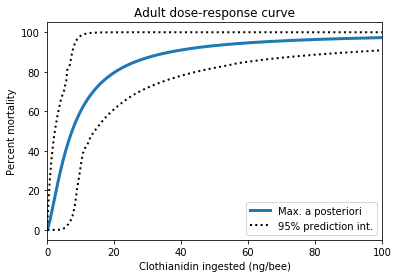

In [277]:
### Plot MAP and 95% Prediction interval

def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = (10**row[0]) * 1000
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = (10**row[2]) * 1000
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=500, title="Dose-response curve"):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        ld50_MAP =  (10**ld50_MAP) * 1000 #unlog transform and convert to ng/bee
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        ld50_MAP =  (10**ld50_MAP) * 1000 #unlog transform and convert to ng/bee
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    plt.show()

#for adults
random.seed(1251)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve")

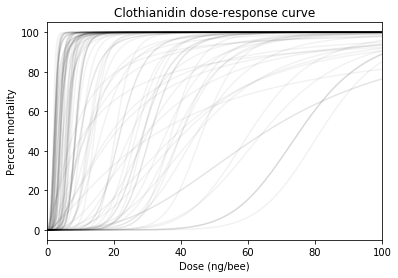

In [282]:
# Multi line plot for larvae
random.seed(1251)
sample = draw_posterior(df, w, 100)

plot_all_dr(sample, xlim=100, adult=False)

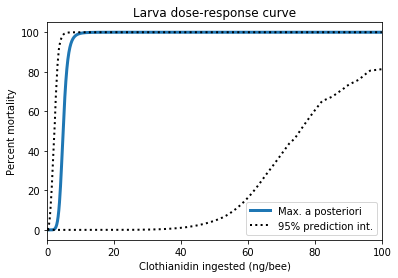

In [278]:
# MAP and PI plot for larvae
random.seed(1251)
plot_dr_map(df, percent=95, adult=False, title = "Larva dose-response curve")